## Rover Project Test Notebook

In [ ]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob

## Data Exploration

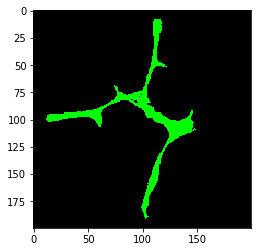

In [13]:
def load_ground_truth_map(filename='calibration_images/map_bw.png'):
    """Load the image of the ground truth map.

    :param filename: string
        File name. A black-and-white image is expected.

    :return ground_truth_3d: numpy.ndarray
        RGB ground truth map with drivable terrain in green and
        others in black.
    """
    ground_truth = mpimg.imread(filename)
    assert (len(ground_truth.shape) == 2)

    ground_truth_3d = \
        np.dstack((ground_truth * 0, ground_truth * 255, ground_truth * 0)).astype(np.uint8)

    return ground_truth_3d


ground_truth_3d = load_ground_truth_map()

plt.imshow(ground_truth_3d)

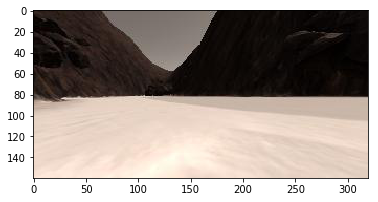

In [17]:
# Grab a random image and display it

path = 'test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Data Processing pipeline

### Calibration Data
Read in and display example grid and rock sample calibration images.

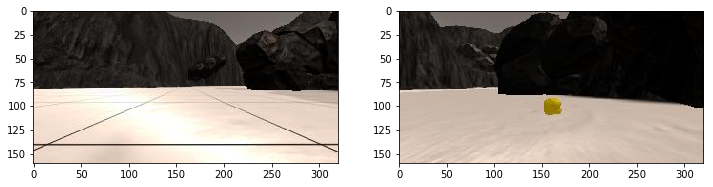

In [18]:
example_grid = 'calibration_images/example_grid1.jpg'
example_rock = 'calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

### Perspective Transform

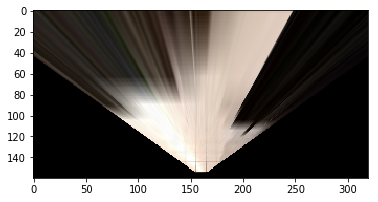

In [5]:
def perspective_transform(img, grid_size=10, bottom_shift=6):
    """Apply perspective transform

    The 'src' points form a 1 m x 1 m square. If "grid_size" is 10
    pixel, then 1 pixel corresponds to 0.1 m in real space.

    :param img: numpy.ndarray
        Original image.
    :param grid_size: int
        Size (pixel) of the grid in the destination image
    :param bottom_shift: int
        Geometric parameter. The bottom of the image is not the rover
        but some place in front of it.

    :return: numpy.ndarray
        Warped image.
    """
    src = np.float32([[14, 140], [118, 96], [200, 96], [301, 140]])
    dst = np.float32([[img.shape[1] / 2 - grid_size / 2,
                       img.shape[0] - bottom_shift],
                      [img.shape[1] / 2 - grid_size / 2,
                       img.shape[0] - bottom_shift - grid_size],
                      [img.shape[1] / 2 + grid_size / 2,
                       img.shape[0] - bottom_shift - grid_size],
                      [img.shape[1] / 2 + grid_size / 2,
                       img.shape[0] - bottom_shift]])

    p_matrix = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(img, p_matrix, (img.shape[1], img.shape[0]))

    return warped


warped = perspective_transform(grid_img, grid_size=10)
plt.imshow(warped)

#scipy.misc.imsave('../output/warped_example.jpg', warped)

### Color Thresholding

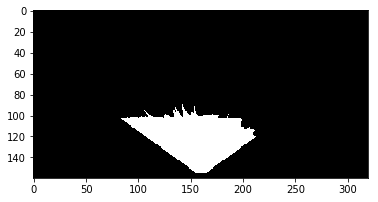

In [11]:
from threshold import Threshold

def get_terrain_binary(warped):
    """Apply color threshold to identify navigable terrain"""
    th1 = Threshold(warped, color_space='hls', channel=1)
    th1.transform(thresh=(180, 255))
    terrain_binary = th1.binary
    
    return terrain_binary


terrain_binary = get_terrain_binary(warped)

plt.imshow(terrain_binary, cmap='gray')

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations

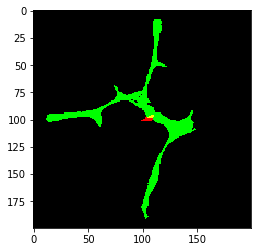

In [19]:
# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles


def rover_to_world(img, x0, y0, yaw, scale=0.1, shape=None):
    """Apply affine transformation

    :param img: numpy.ndarray
        Original image.
    :param x0: int/float
        x coordinate of the rover in the world map
    :param y0: int/float
        y coordinate of the rover in the world map
    :param yaw: int/float
        yaw angle of the rover (in degree)
    :param scale: int/float
        Scale of the original image
    :param shape: None/tuple
        Shape of the destination image. If None, it is the shape of the original image
    """
    if shape is None:
        shape = img.shape

    yaw = yaw * np.pi / 180  # convert yaw to radian

    alpha = scale * np.cos(yaw)
    beta = scale * np.sin(yaw)

    # matrix of the affine transform
    M = np.zeros((2, 3))

    M[0, 0] = alpha
    M[0, 1] = beta
    M[0, 2] = (1 - alpha) * x0 - beta * y0
    M[1, 0] = -beta
    M[1, 1] = alpha
    M[1, 2] = beta * x0 + (1 - alpha) * y0

    warped = cv2.warpAffine(img, M, (shape[1], shape[0]))

    return warped


# Convert rover-centric pixel values to world coords
affine_warped = rover_to_world(terrain_binary, 100, 100, 30, shape=(200, 200))

# dist, angles = to_polar_coords(xpix, ypix)
# mean_dir = np.mean(angles)

ground_truth_3d_copy = np.copy(ground_truth_3d)
ground_truth_3d_copy[:, :, 0] += affine_warped*255

plt.imshow(ground_truth_3d_copy)


## Make a video from processed image data  

In [22]:
import pandas as pd


data = pd.read_csv('test_dataset/robot_log.csv', delimiter=';', decimal='.')

print(data.shape)
print(data.head())


def generate(data):
    """Generate data used in image processing
    
    :param data: pandas.DataFrame
        Rover's log data.
        
    :return: generator of a list (x, y, yaw)
    """
    for i in range(data.shape[0]):
        yield (data.ix[i, 'X_Position'], data.ix[i, 'Y_Position'], data.ix[i, 'Yaw'])

        
def process_image_(data_generator, ground_truth_map):
    """A decorator to the process_image() function
    
    The decorator is used to pass additional arguments to the function which can
    not take more than one argument.
    
    :param data_generator: generator
        Generate the data
    :param ground_truth_3d: numpy.ndarray
        Ground truth map.
        
    :return: numpy.ndarray
        Output image.
    """
    def warp(f):
        def wrapped_f(img):
            # perspective transform
            perspective_warped = perspective_transform(img, grid_size=10)

            # color threshold
            terrain_binary = get_terrain_binary(perspective_warped)
            
            x0, y0, yaw = next(data_generator)
            # Map the local image to the world map
            affine_warped = rover_to_world(terrain_binary, x0, y0, yaw, shape=ground_truth_map.shape)

            # Update worldmap (to be displayed on right side of screen)
            world_map = np.copy(ground_truth_map)
            world_map[:, :, 0] += affine_warped*255
            world_map[int(y0)-2:int(y0)+3, int(x0)-2:int(x0)+3, 0:3] = 255

            # Create a blank image
            output_image = np.zeros((img.shape[0] + world_map.shape[0], img.shape[1]*2, 3))

            output_image[0:img.shape[0], 0:img.shape[1]] = img  # upper left part

            output_image[0:img.shape[0], img.shape[1]:] = perspective_warped  # upper right part

            output_image[img.shape[0]:, 0:world_map.shape[1]] = world_map  # lower left part +

            # Then putting some text over the image
            cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
            
            return output_image
        return wrapped_f
    return warp


@process_image_(generate(data), ground_truth_3d)
def process_image(img):
    """This is a dummy function"""
    pass


(283, 10)
                                                Path  SteerAngle  Throttle  \
0  test_dataset/IMG/robocam_2017_05_02_11_16_21_4...         0.0       0.0   
1  test_dataset/IMG/robocam_2017_05_02_11_16_21_4...         0.0       0.0   
2  test_dataset/IMG/robocam_2017_05_02_11_16_21_4...         0.0       0.0   
3  test_dataset/IMG/robocam_2017_05_02_11_16_21_5...         0.0       0.0   
4  test_dataset/IMG/robocam_2017_05_02_11_16_21_6...         0.0       0.0   

   Brake  Speed  X_Position  Y_Position     Pitch       Yaw          Roll  
0    1.0    0.0    99.66999    85.58897  0.000236  56.82555  2.093137e-07  
1    0.0    0.0    99.66999    85.58897  0.000236  56.82555  2.299884e-07  
2    0.0    0.0    99.66999    85.58897  0.000236  56.82555  2.299884e-07  
3    0.0    0.0    99.66999    85.58897  0.000236  56.82555  2.299884e-07  
4    0.0    0.0    99.66999    85.58897  0.000236  56.82555  2.299884e-07  


In [21]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


output = 'output/test_mapping.mp4'  # Define pathname to save the output video

# create new video clip
clip = ImageSequenceClip(data.Path.tolist(), fps=25)
new_clip = clip.fl_image(process_image)

%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output/test_mapping.mp4
[MoviePy] Writing video output/test_mapping.mp4


100%|█████████▉| 282/283 [00:01<00:00, 158.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/test_mapping.mp4 

CPU times: user 1.53 s, sys: 60 ms, total: 1.59 s
Wall time: 1.96 s


In [24]:
import io
import base64


# play the video
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))